# 1. Исследовательский анализ данных

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# < Перенесите сюда исследовательский анализ данных >
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


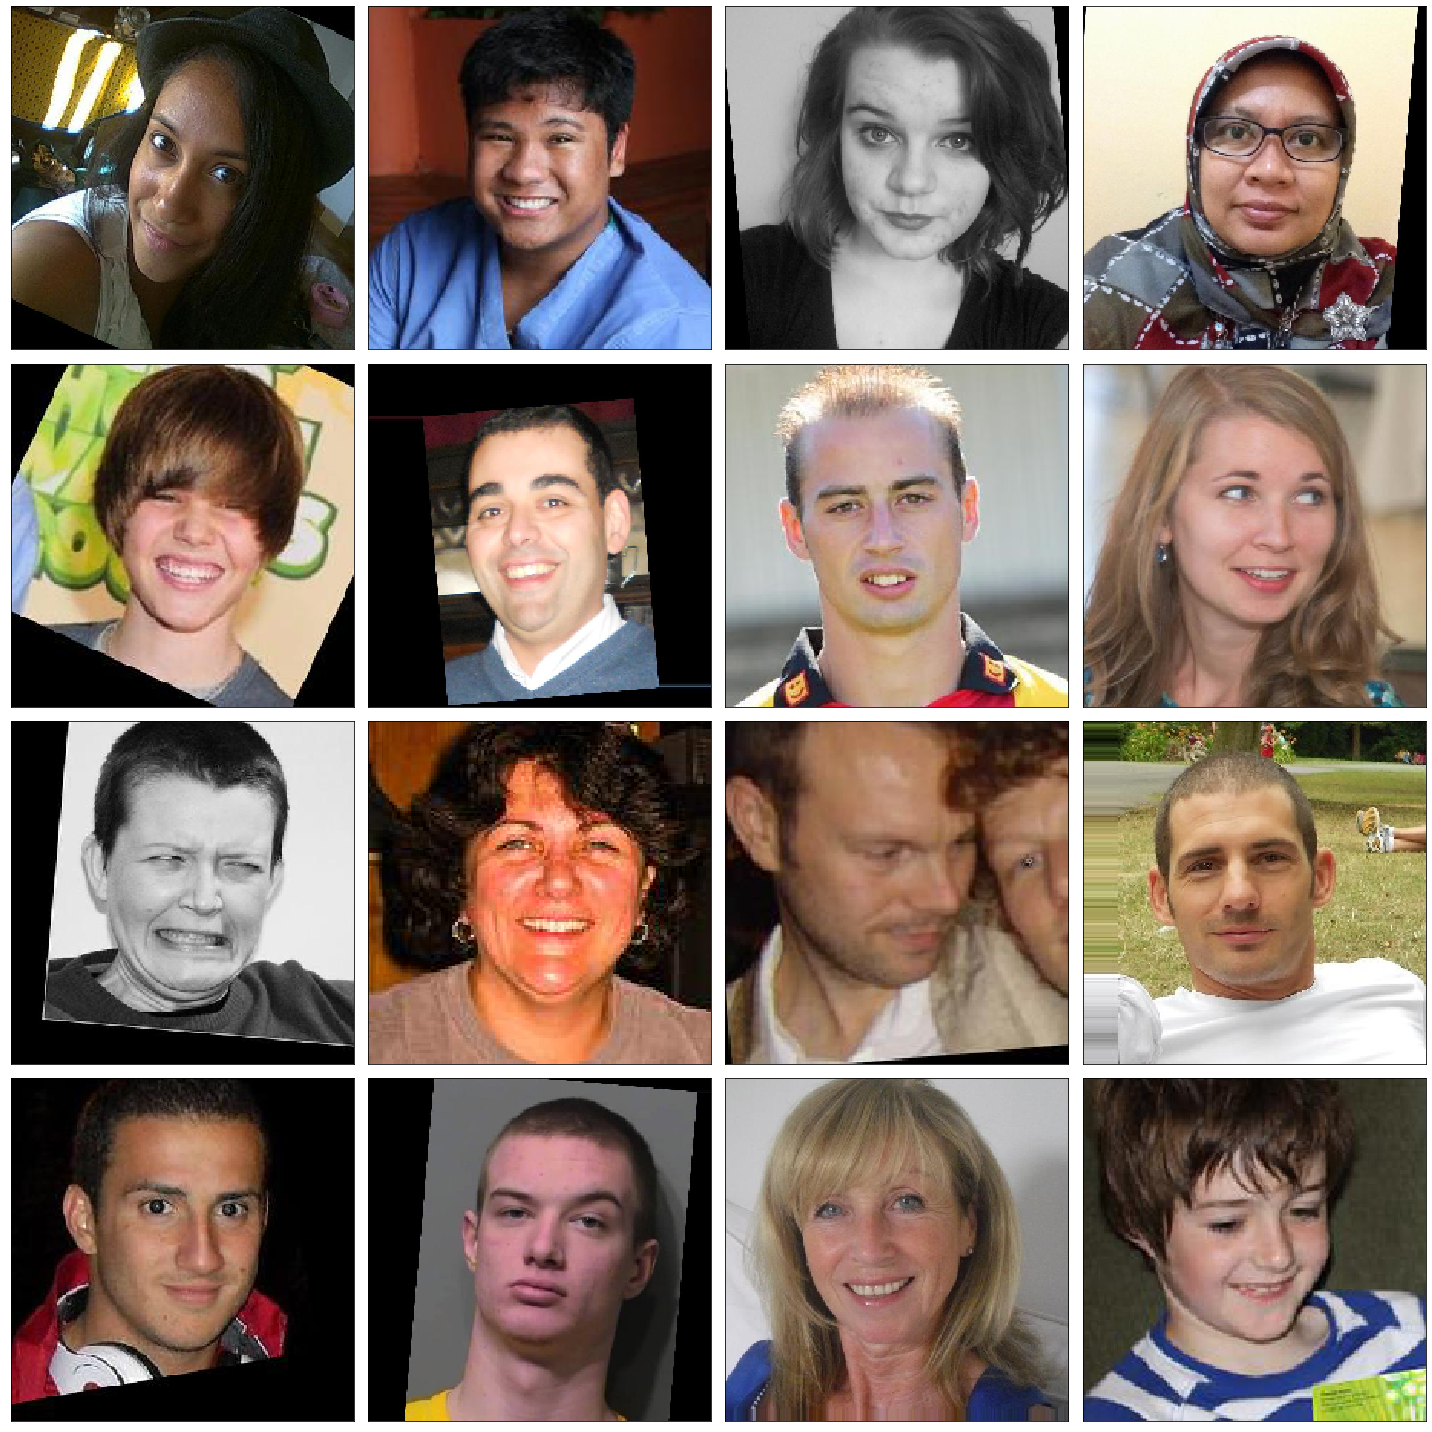

In [16]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [6]:
target

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3342f7910>]],
      dtype=object)

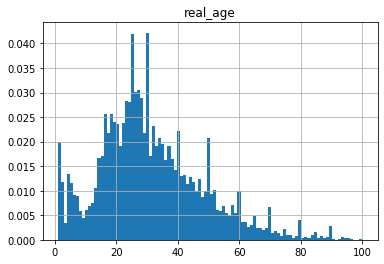

In [10]:
labels.hist(bins=100,density=True)

# в целом нормально распределны. младьшего возраста чуть больше, это сделано для того
#что бы распределение осталось нормальным в обе стороны т.к возраст не может уйти в минус.

In [13]:
#цветовые параметры картинок.

#если бы у нас были два датасета на трейн и тест можно было бы их сравнить,
#но в данном случае мы сами берем тест из выборки и значит параметры будут соответстовать
print('Parametrs: ', features.min(), features.max(), features.mean(), features.std())


Parametrs:  0.0 1.0 0.37516916 0.29559135


In [ ]:
#повороты картинок просто так нельзя посомтреть, 
#но визуально судя по выборке они все вертикальные с небольшой аугментацией.

Вывод. Мы рассмотерли датасет. Возраст распределен нормально, фото выровнены. Среднее значение цвета 0.37 со стандартным отклонением  0.29. Датасает представлен с  аугментацией на накоторых фотоографиях в виде поворотов, размытия, сдвига, но без вертикального флипа.

Данные готовы к обработке.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    lables = pd.read_csv(path+'lables.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_data_g = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,subset='training')
    return train_data_g

def load_test(path):
    lables = pd.read_csv(path+'lables.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
     test_data_g = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,subset='validation')
    return test_data_g


def create_model(input_shape):
    optimizer= Adam()
    backbone = ResNet50(input_shape=input_shape,weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss="mean_squared_error",optimizer=optimizer, metrics=["mean_absolute_error"])
    return model


def train_model(model, train_data, test_data,batch_size=None,epochs=10, steps_per_epoch =None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, epochs=epochs)
    return model
```


# 3. Анализ обученной модели

UPD2.

выполнил на kaggle gpu : https://www.kaggle.com/vitaliymalcev/detecting-age-by-photo-with-keras

доплнительные аугментации и изменение Adam только ухудшали результат.
В итоге оставил единственную аугментацию по горизонатльному флипу и сделал обучение во много эпох с ранней остановкой.
лучший результат который удалось достигнуть:
Epoch 58/300
178/178 [==============================] - 122s 687ms/step - loss: 3.6659 - mean_absolute_error: 1.4431 - val_loss: 74.4933 - val_mean_absolute_error: 6.4688
